# ML Assignment 1 : Logistic Regression


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm #To add progress bars

df = pd.read_csv('data.csv')

%matplotlib inline
np.random.seed(2022)

Feature Engineering 1 & 2

In [2]:

df.replace({"M": 1, "B": 0}, inplace=True) # M = 1 and B = 0

# norm = (df - df.mean(axis =0))/df.std(axis=0)
# norm["diagnosis"] = df["diagnosis"]
# norm = norm.fillna(norm.mean()) # replaced categorical missing values with most frequent
# df = df.fillna(df.mean()) # replaced categorical missing values with most frequent
# df.head()
df = df.dropna()


x = df.drop(['diagnosis','id'],axis=1)
y = df['diagnosis']
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [4]:
#Shuffling the data to prevent any systematic ordering in the dataset 
#that could influence the performance of our model.
def shuffle(X, y):
    '''
        Shuffles rows of a dataframe and returns shuffled dataframe
    '''
    permute = np.random.permutation(len(X))
    return X[permute], y[permute]

In [5]:
#To scale down the data between 0 and 1
class MinMaxScaler():
    '''
        Class to normalize a pandas dataframe
    '''
    def fit(self, X):
        self.X = X
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        
    def fit_transform(self, X):
        self.X = X
        self.fit(X)
        return self.transform(X)
    
    def transform(self, X):
        if (isinstance(X, np.ndarray)):
            return ((X - np.array(self.min)) / (np.array(self.max) - np.array(self.min)))
        return (X - self.min) / (self.max - self.min)
     #returns a tuple containing the minimum and maximum values calculated during the normalization process.   
    def get_params():
        return self.min, self.max

In [6]:
## Train test split
def train_test_split(X, y, test_size=0.33):
    '''
        Splits data into train-test split
            
            Parameters:
                X : Features
                y : Labels
                test_size : Fraction of data to use for test set
            
            Returns:
                (X_train, y_train, X_test, y_test) : Train test split
    '''
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
        
    X, y = shuffle(X, y)
        
    test_indices = np.random.rand(X.shape[0]) < test_size
    return X[~test_indices], y[~test_indices], X[test_indices], y[test_indices]

In [7]:
#To generate 10 different train-test splits, and get an average performance of the model
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []
for i in range(10):
    X_train, y_train, X_test, y_test = train_test_split(x, y)
    scaler = MinMaxScaler()
    X_train_scaled = np.array(scaler.fit_transform(X_train))
    X_test_scaled = np.array(scaler.transform(X_test))
    X_train_list.append(X_train_scaled)
    y_train_list.append(y_train)
    X_test_list.append(X_test_scaled)
    y_test_list.append(y_test)

In [8]:
# Batch Gradient Descent

In [9]:
class LogisticRegressionBGD():
  #Initialise hyperparameters regularization, threshold etc.
    def __init__(self, lamda = 0, threshold = 0.5,include_bias=True):
        self.losses = []
        self.epoch_losses = []
        self.lamda = lamda
        self.include_bias = include_bias
        self.accs = []
        self.threshold = threshold
        
    def fit(self, X, y, alpha, max_epochs=500000, threshold = 0.5,show_loss=False):
        X_orig = X.copy()
        if self.include_bias:
            X = self.__pad_ones__(X)
        self.coeffs = np.zeros((X.shape[1],))
        m = X.shape[0]
        self.losses = []
        self.accs = []
        epoch = 0
        pbar = tqdm(total=max_epochs)
        while(epoch < max_epochs):
            preds = self.__predict__(X).reshape(y.shape)
            loss = -(1 / m) * (np.sum((y * np.log(preds)) + (1 - y) * np.log(1 - preds)))
            self.losses.append(loss)
            
            self.coeffs -= ((alpha / m) * np.sum(np.expand_dims((preds - y), axis=1) * X, axis=0))
            self.accs.append(self.evaluate(X_orig, y))     
            if (show_loss==True and epoch % 50 == 0):
                print(f'Loss at epoch {epoch}: {self.losses[-1]} : Accuracy: {self.evaluate(X_orig, y)}')
            if (len(self.losses) > 2 and abs(np.mean(self.losses[-11:]) - loss) < 10e-7):
                print('Converged, stopping early.')
                break
            epoch += 1
            pbar.update(1)
        pbar.close()
        
    def get_loss(self, X, y_true):
        y_pred = self.predict_proba(X)
        return -(1 / len(y_true)) * (np.sum((y_true * np.log(y_pred)) + (1 - y_true) * np.log(1 - y_pred)))

    def __predict__(self, X):
        z = X @ self.coeffs
        return 1 / ((1+np.exp(-(z)))+ 10e-8 ) # Subtract eps for numerical stability and avoid log(0) in CE loss
    
    def predict_proba(self, X):
        X = self.__pad_ones__(X)
        return self.__predict__(X)
    
    def predict(self, X):
        preds = self.predict_proba(X)
        preds[preds >= self.threshold] = 1
        preds[preds < self.threshold] = 0
        return preds
    
    def evaluate(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / len(y)
    
    def __pad_ones__(self, X):
        pad_ones = np.ones(X.shape[0]).reshape((-1, 1))
        return np.concatenate((pad_ones, X), axis=1)
    
    def get_coeffs(self):
        return self.coeffs
    
    def get_precision(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / (np.sum(preds == y) + np.sum(np.logical_and(np.logical_not(y), preds)))
    
    def get_recall(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / (np.sum(preds == y) + np.sum(np.logical_and(y, np.logical_not(preds))))

In [10]:
#Stochastic Gradient Descent

In [11]:
class LogisticRegressionSGD():
    def __init__(self, lamda = 0, threshold = 0.5,include_bias=True):
        self.losses = []
        self.accs = []
        self.epoch_losses = []
        self.lamda = lamda
        self.include_bias = include_bias
        self.threshold = threshold
        
    def fit(self, X, y, alpha, max_iters=500000, show_loss=False):
        X_orig = X.copy()
        if (self.include_bias):
            X = self.__pad_ones__(X)
        self.coeffs = np.zeros((X.shape[1],))
        m = X.shape[0]
        self.losses = []
        self.accs = []
        it = 0
        pbar = tqdm(total=max_iters)
        while(it < max_iters):
            for x, yi in zip(X, y):
                preds = self.__predict__(x)
                loss = -((yi * np.log(preds)) + (1 - yi) * np.log(1 - preds))
                self.losses.append(loss)

                self.coeffs -= (alpha) * ((preds - yi) * x)
                self.accs.append(self.evaluate(X_orig, y))  
                it += 1
                pbar.update(1)
                if (show_loss==True and it % 50 == 0):
                    print(f'Loss at iteration {it}: {self.losses[-1]} : Accuracy: {self.evaluate(X_orig, y)}')
            self.epoch_losses.append(self.losses[-1])
            if (len(self.losses) > 2 and abs(np.mean(self.losses[-11 * len(y):]) - loss) < 10e-7):
                print('Converged, stopping early.')
                break
        pbar.close()
        
    def get_loss(self, X, y_true):
        y_pred = self.predict_proba(X)
        return -(1 / len(y_true)) * (np.sum((y_true * np.log(y_pred)) + (1 - y_true) * np.log(1 - y_pred)))

    def __predict__(self, X):
        z = X @ self.coeffs
        return 1 / ((1+np.exp(-(z))) + 10e-8) # Subtract eps for numerical stability and avoid log(0) in CE loss
    
    def predict_proba(self, X):
        X = self.__pad_ones__(X)
        return self.__predict__(X)
    
    def predict(self, X):
        preds = self.predict_proba(X)
        preds[preds >= self.threshold] = 1
        preds[preds < self.threshold] = 0
        return preds
    
    def evaluate(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / len(y)
    
    def __pad_ones__(self, X):
        pad_ones = np.ones(X.shape[0]).reshape((-1, 1))
        return np.concatenate((pad_ones, X), axis=1)
    
    def get_coeffs(self):
        return self.coeffs
    
    def get_precision(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / (np.sum(preds == y) + np.sum(np.logical_and(np.logical_not(y), preds)))
    
    def get_recall(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / (np.sum(preds == y) + np.sum(np.logical_and(y, np.logical_not(preds))))

In [12]:
## Mini Batch Gradient Descent

In [13]:
class LogisticRegressionMBGD():
    def __init__(self, lamda = 0, threshold = 0.5,include_bias=True):
        self.losses = []
        self.epoch_losses = []
        self.lamda = lamda
        self.include_bias = include_bias
        self.accs = []
        self.threshold = threshold
        
    def fit(self, X, y, alpha, max_epochs=500000, batch_size = 20,show_loss=False):
        X_orig = X.copy()
        if self.include_bias:
            X = self.__pad_ones__(X)
        self.coeffs = np.zeros((X.shape[1],))
        m = X.shape[0]
        self.losses = []
        self.accs = []
        epoch = 0
        pbar = tqdm(total=max_epochs)
        X_batch_list, y_batch_list = self.prepare_batches(X, y, batch_size)
        while(epoch < max_epochs):
          for i in range (len(y_batch_list)):
            X_batch = X_batch_list[i]
            y_batch = y_batch_list[i]
            preds = self.__predict__(X_batch).reshape(y_batch.shape)
            loss = -(1 / m) * (np.sum((y_batch * np.log(preds)) + (1 - y_batch) * np.log(1 - preds)))
            self.losses.append(loss)
            
            self.coeffs -= ((alpha / m) * np.sum(np.expand_dims((preds - y_batch), axis=1) * X_batch, axis=0))
            self.accs.append(self.evaluate(X_orig, y))     
          if (show_loss==True and epoch % 50 == 0):
              print(f'Loss at epoch {epoch}: {self.losses[-1]} : Accuracy: {self.evaluate(X_orig, y)}')
          if (len(self.losses) > 2 and abs(np.mean(self.losses[-11:]) - loss) < 10e-7):
              print('Converged, stopping early.')
              break
          epoch += 1
          pbar.update(1)
        pbar.close()
   
    def prepare_batches(self, X, y, batch_size):
      X_batch_list = list()
      y_batch_list = list()
      
      for i in range(len(y) // batch_size):
          X_batch_list.append(X[i * batch_size : i * batch_size + batch_size, :])
          y_batch_list.append(y[i * batch_size : i * batch_size + batch_size])
      
      if len(y) % batch_size > 0:
          X_batch_list.append(X[len(y) // batch_size * batch_size:, :])
          y_batch_list.append(y[len(y) // batch_size * batch_size:])

      return X_batch_list, y_batch_list
        
    def get_loss(self, X, y_true):
        y_pred = self.predict_proba(X)
        return -(1 / len(y_true)) * (np.sum((y_true * np.log(y_pred)) + (1 - y_true) * np.log(1 - y_pred)))

    def __predict__(self, X):
        z = X @ self.coeffs
        return 1 / ((1+np.exp(-(z))) + 10e-8) # Subtract eps for numerical stability and avoid log(0) in CE loss
    
    def predict_proba(self, X):
        X = self.__pad_ones__(X)
        return self.__predict__(X)
    
    def predict(self, X):
        preds = self.predict_proba(X)
        preds[preds >= self.threshold] = 1
        preds[preds < self.threshold] = 0
        return preds
    
    def evaluate(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / len(y)
    
    def __pad_ones__(self, X):
        pad_ones = np.ones(X.shape[0]).reshape((-1, 1))
        return np.concatenate((pad_ones, X), axis=1)
    
    def get_coeffs(self):
        return self.coeffs
    
    def get_precision(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / (np.sum(preds == y) + np.sum(np.logical_and(np.logical_not(y), preds)))
    
    def get_recall(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / (np.sum(preds == y) + np.sum(np.logical_and(y, np.logical_not(preds))))

# BGD - Different thresholds


In [14]:
losses_gd_train = []
accuracies_gd_train = []
precisions_gd_train = []
recall_gd_train = []
losses_gd = []
accuracies_gd = []
precisions_gd = []
recall_gd = []
#0.5
for i in range(10):
    logregGD = LogisticRegressionBGD(threshold = 0.5)
    logregGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_epochs=1000)
    accuracies_gd.append(logregGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_gd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_gd.append(logregGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_gd.append(logregGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_gd_train.append(logregGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_gd_train.append(logregGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_gd_train.append(logregGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_gd_train.append(logregGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_gd = (2 * np.array(precisions_gd) * np.array(recall_gd)) / (np.array(precisions_gd) + np.array(recall_gd))
f1_gd_tr = (2 * np.array(precisions_gd_train) * np.array(recall_gd_train)) / (np.array(precisions_gd_train) + np.array(recall_gd_train))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
print('Mean for metric parameters')
print(f'Train BGD: Loss: {np.mean(losses_gd_train)}; Accuracy: {np.mean(accuracies_gd_train)}; Recall: {np.mean(recall_gd_train)}; Precision: {np.mean(precisions_gd_train)}; F1: {np.mean(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.mean(losses_gd)}; Accuracy: {np.mean(accuracies_gd)}; Recall: {np.mean(recall_gd)}; Precision: {np.mean(precisions_gd)}; F1: {np.mean(f1_gd)}')


Mean for metric parameters
Train BGD: Loss: 0.49149675829561873; Accuracy: 0.9065717554676601; Recall: 0.9085138942445609; Precision: 0.9976489293948532; F1: 0.9509755919245448
Test BGD: Loss: 0.5000877464720095; Accuracy: 0.8817970587123259; Recall: 0.885228286346789; Precision: 0.995676338375403; F1: 0.9370386198210161


In [16]:
print('Variance for metric parameters')
print(f'Train BGD: Loss: {np.std(losses_gd_train)}; Accuracy: {np.std(accuracies_gd_train)}; Recall: {np.std(recall_gd_train)}; Precision: {np.std(precisions_gd_train)}; F1: {np.std(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.std(losses_gd)}; Accuracy: {np.std(accuracies_gd)}; Recall: {np.std(recall_gd)}; Precision: {np.std(precisions_gd)}; F1: {np.std(f1_gd)}')

Variance for metric parameters
Train BGD: Loss: 0.005717654217546977; Accuracy: 0.008553464281791576; Recall: 0.008423331817388822; Precision: 0.0021970739486492255; F1: 0.004712448997714552
Test BGD: Loss: 0.006055759438747734; Accuracy: 0.02218702411150722; Recall: 0.022860182739549595; Precision: 0.003912829691475956; F1: 0.01251317109271499


In [17]:
logregBGD = LogisticRegressionBGD()
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
losses1_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
losses2_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
losses3_bgd = logregBGD.losses

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

array([-1.05403861e-02,  3.00288780e-03, -3.87327396e-04,  3.10861172e-03,
        3.15025115e-03, -2.37974557e-03,  1.73267657e-03,  3.98702268e-03,
        4.77825407e-03, -1.73559763e-03, -3.37122108e-03,  1.65600899e-03,
       -1.97573577e-03,  1.49588318e-03,  1.68140056e-03, -2.35243545e-03,
       -3.10589166e-04, -9.28553468e-05, -2.77447472e-04, -1.67199365e-03,
       -1.19153140e-03,  4.42132757e-03,  4.20198462e-05,  4.28788290e-03,
        4.34660706e-03, -1.29026494e-03,  1.77935306e-03,  2.76345261e-03,
        4.52050159e-03, -3.09894677e-04, -4.00734217e-04])

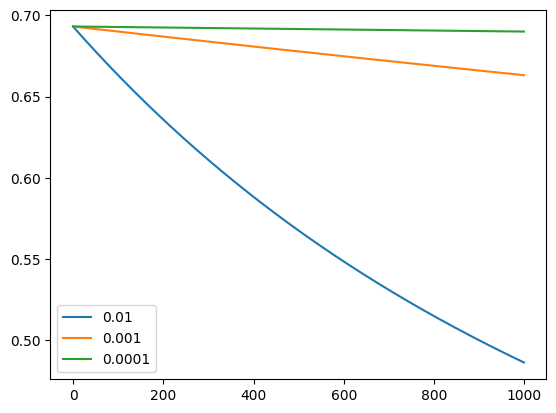

In [18]:
plt.plot(range(len(losses1_bgd)), losses1_bgd, label=0.01)
plt.plot(range(len(losses2_bgd)), losses2_bgd, label=0.001)
plt.plot(range(len(losses3_bgd)), losses3_bgd, label=0.0001)
plt.legend()
logregBGD.coeffs

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train BGD: Loss: 0.49149675829561873; Accuracy: 0.46668990341761374; Recall: 1.0; Precision: 0.46668990341761374; F1: 0.6362728665141246
Test BGD: Loss: 0.5000877464720095; Accuracy: 0.4693660378341762; Recall: 1.0; Precision: 0.4693660378341762; F1: 0.6382914653416757


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.05403861e-02  3.00288780e-03 -3.87327396e-04  3.10861172e-03
  3.15025115e-03 -2.37974557e-03  1.73267657e-03  3.98702268e-03
  4.77825407e-03 -1.73559763e-03 -3.37122108e-03  1.65600899e-03
 -1.97573577e-03  1.49588318e-03  1.68140056e-03 -2.35243545e-03
 -3.10589166e-04 -9.28553468e-05 -2.77447472e-04 -1.67199365e-03
 -1.19153140e-03  4.42132757e-03  4.20198462e-05  4.28788290e-03
  4.34660706e-03 -1.29026494e-03  1.77935306e-03  2.76345261e-03
  4.52050159e-03 -3.09894677e-04 -4.00734217e-04]
Variance for metric parameters
Train BGD: Loss: 0.005717654217546977; Accuracy: 0.008553464281791576; Recall: 0.008423331817388822; Precision: 0.0021970739486492255; F1: 0.012378368325956972
Test BGD: Loss: 0.006055759438747734; Accuracy: 0.030568391063096927; Recall: 0.0; Precision: 0.030568391063096927; F1: 0.027756188650573374


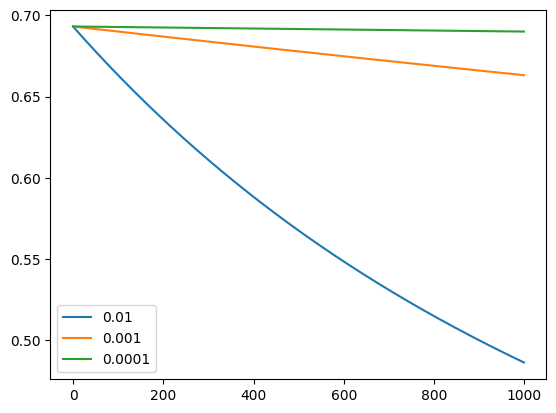

In [19]:
## 0.3
losses_gd_tr = []
accuracies_gd_tr = []
precisions_gd_tr = []
recall_gd_tr = []
losses_gd = []
accuracies_gd = []
precisions_gd = []
recall_gd = []

for i in range(10):
    logregGD = LogisticRegressionBGD(threshold = 0.3)
    logregGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_epochs=1000)
    accuracies_gd.append(logregGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_gd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_gd.append(logregGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_gd.append(logregGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_gd_tr.append(logregGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_gd_tr.append(logregGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_gd_tr.append(logregGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_gd_tr.append(logregGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_gd = (2 * np.array(precisions_gd) * np.array(recall_gd)) / (np.array(precisions_gd) + np.array(recall_gd))
f1_gd_tr = (2 * np.array(precisions_gd_tr) * np.array(recall_gd_tr)) / (np.array(precisions_gd_tr) + np.array(recall_gd_tr))
print(f'Train BGD: Loss: {np.mean(losses_gd_tr)}; Accuracy: {np.mean(accuracies_gd_tr)}; Recall: {np.mean(recall_gd_tr)}; Precision: {np.mean(precisions_gd_tr)}; F1: {np.mean(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.mean(losses_gd)}; Accuracy: {np.mean(accuracies_gd)}; Recall: {np.mean(recall_gd)}; Precision: {np.mean(precisions_gd)}; F1: {np.mean(f1_gd)}')
logregBGD = LogisticRegressionBGD(threshold = 0.3)
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
losses1_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
losses2_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
losses3_bgd = logregBGD.losses
plt.plot(range(len(losses1_bgd)), losses1_bgd, label=0.01)
plt.plot(range(len(losses2_bgd)), losses2_bgd, label=0.001)
plt.plot(range(len(losses3_bgd)), losses3_bgd, label=0.0001)
plt.legend()
print(logregBGD.coeffs)
print('Variance for metric parameters')
print(f'Train BGD: Loss: {np.std(losses_gd_train)}; Accuracy: {np.std(accuracies_gd_train)}; Recall: {np.std(recall_gd_train)}; Precision: {np.std(precisions_gd_train)}; F1: {np.std(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.std(losses_gd)}; Accuracy: {np.std(accuracies_gd)}; Recall: {np.std(recall_gd)}; Precision: {np.std(precisions_gd)}; F1: {np.std(f1_gd)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train BGD: Loss: 0.49149675829561873; Accuracy: 0.8519704326711703; Recall: 0.9938360843596665; Precision: 0.8565701939975299; F1: 0.9199517462587495
Test BGD: Loss: 0.5000877464720095; Accuracy: 0.8622174444361275; Recall: 0.9875281071983417; Precision: 0.8718116115104536; F1: 0.9257401645186736


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.05403861e-02  3.00288780e-03 -3.87327396e-04  3.10861172e-03
  3.15025115e-03 -2.37974557e-03  1.73267657e-03  3.98702268e-03
  4.77825407e-03 -1.73559763e-03 -3.37122108e-03  1.65600899e-03
 -1.97573577e-03  1.49588318e-03  1.68140056e-03 -2.35243545e-03
 -3.10589166e-04 -9.28553468e-05 -2.77447472e-04 -1.67199365e-03
 -1.19153140e-03  4.42132757e-03  4.20198462e-05  4.28788290e-03
  4.34660706e-03 -1.29026494e-03  1.77935306e-03  2.76345261e-03
  4.52050159e-03 -3.09894677e-04 -4.00734217e-04]


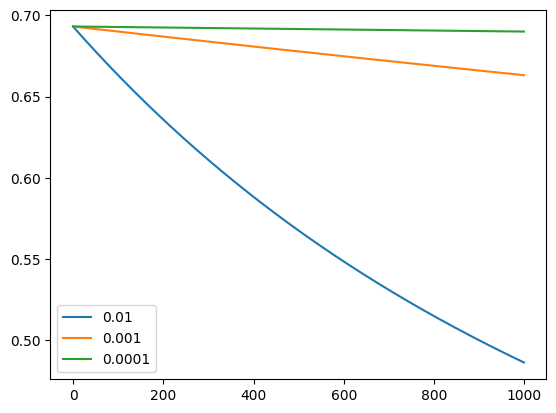

In [20]:
## 0.4
losses_gd_tr = []
accuracies_gd_tr = []
precisions_gd_tr = []
recall_gd_tr = []
losses_gd = []
accuracies_gd = []
precisions_gd = []
recall_gd = []

for i in range(10):
    logregGD = LogisticRegressionBGD(threshold = 0.4)
    logregGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_epochs=1000)
    accuracies_gd.append(logregGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_gd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_gd.append(logregGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_gd.append(logregGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_gd_tr.append(logregGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_gd_tr.append(logregGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_gd_tr.append(logregGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_gd_tr.append(logregGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_gd = (2 * np.array(precisions_gd) * np.array(recall_gd)) / (np.array(precisions_gd) + np.array(recall_gd))
f1_gd_tr = (2 * np.array(precisions_gd_tr) * np.array(recall_gd_tr)) / (np.array(precisions_gd_tr) + np.array(recall_gd_tr))
print(f'Train BGD: Loss: {np.mean(losses_gd_tr)}; Accuracy: {np.mean(accuracies_gd_tr)}; Recall: {np.mean(recall_gd_tr)}; Precision: {np.mean(precisions_gd_tr)}; F1: {np.mean(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.mean(losses_gd)}; Accuracy: {np.mean(accuracies_gd)}; Recall: {np.mean(recall_gd)}; Precision: {np.mean(precisions_gd)}; F1: {np.mean(f1_gd)}')
logregBGD = LogisticRegressionBGD(threshold = 0.4)
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
losses1_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
losses2_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
losses3_bgd = logregBGD.losses
plt.plot(range(len(losses1_bgd)), losses1_bgd, label=0.01)
plt.plot(range(len(losses2_bgd)), losses2_bgd, label=0.001)
plt.plot(range(len(losses3_bgd)), losses3_bgd, label=0.0001)
plt.legend()
print(logregBGD.coeffs)

In [21]:
print('Variance for metric parameters')
print(f'Train BGD: Loss: {np.std(losses_gd_train)}; Accuracy: {np.std(accuracies_gd_train)}; Recall: {np.std(recall_gd_train)}; Precision: {np.std(precisions_gd_train)}; F1: {np.std(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.std(losses_gd)}; Accuracy: {np.std(accuracies_gd)}; Recall: {np.std(recall_gd)}; Precision: {np.std(precisions_gd)}; F1: {np.std(f1_gd)}')

Variance for metric parameters
Train BGD: Loss: 0.005717654217546977; Accuracy: 0.008553464281791576; Recall: 0.008423331817388822; Precision: 0.0021970739486492255; F1: 0.011268648093459576
Test BGD: Loss: 0.006055759438747734; Accuracy: 0.02969318631450349; Recall: 0.006462913700218092; Precision: 0.031245222254359627; F1: 0.017023587099515604


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train BGD: Loss: 0.49149675829561873; Accuracy: 0.7745013239633955; Recall: 0.7745013239633955; Precision: 1.0; F1: 0.8727907188857735
Test BGD: Loss: 0.5000877464720095; Accuracy: 0.7436083788116367; Recall: 0.7436083788116367; Precision: 1.0; F1: 0.8526748970184685


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.05403861e-02  3.00288780e-03 -3.87327396e-04  3.10861172e-03
  3.15025115e-03 -2.37974557e-03  1.73267657e-03  3.98702268e-03
  4.77825407e-03 -1.73559763e-03 -3.37122108e-03  1.65600899e-03
 -1.97573577e-03  1.49588318e-03  1.68140056e-03 -2.35243545e-03
 -3.10589166e-04 -9.28553468e-05 -2.77447472e-04 -1.67199365e-03
 -1.19153140e-03  4.42132757e-03  4.20198462e-05  4.28788290e-03
  4.34660706e-03 -1.29026494e-03  1.77935306e-03  2.76345261e-03
  4.52050159e-03 -3.09894677e-04 -4.00734217e-04]


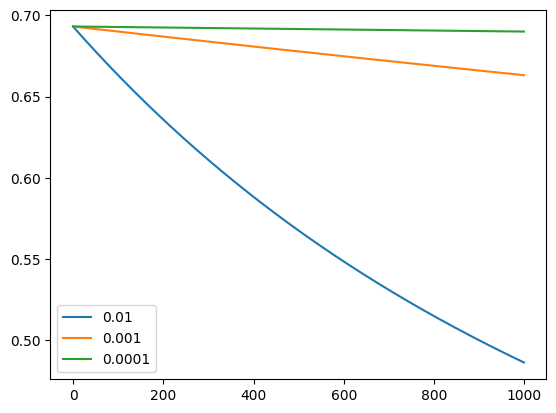

In [22]:
## 0.6
losses_gd_tr = []
accuracies_gd_tr = []
precisions_gd_tr = []
recall_gd_tr = []
losses_gd = []
accuracies_gd = []
precisions_gd = []
recall_gd = []

for i in range(10):
    logregGD = LogisticRegressionBGD(threshold = 0.6)
    logregGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_epochs=1000)
    accuracies_gd.append(logregGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_gd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_gd.append(logregGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_gd.append(logregGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_gd_tr.append(logregGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_gd_tr.append(logregGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_gd_tr.append(logregGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_gd_tr.append(logregGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_gd = (2 * np.array(precisions_gd) * np.array(recall_gd)) / (np.array(precisions_gd) + np.array(recall_gd))
f1_gd_tr = (2 * np.array(precisions_gd_tr) * np.array(recall_gd_tr)) / (np.array(precisions_gd_tr) + np.array(recall_gd_tr))
print(f'Train BGD: Loss: {np.mean(losses_gd_tr)}; Accuracy: {np.mean(recall_gd_tr)}; Recall: {np.mean(recall_gd_tr)}; Precision: {np.mean(precisions_gd_tr)}; F1: {np.mean(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.mean(losses_gd)}; Accuracy: {np.mean(recall_gd)}; Recall: {np.mean(recall_gd)}; Precision: {np.mean(precisions_gd)}; F1: {np.mean(f1_gd)}')
logregBGD = LogisticRegressionBGD(threshold = 0.6)
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
losses1_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
losses2_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
losses3_bgd = logregBGD.losses
plt.plot(range(len(losses1_bgd)), losses1_bgd, label=0.01)
plt.plot(range(len(losses2_bgd)), losses2_bgd, label=0.001)
plt.plot(range(len(losses3_bgd)), losses3_bgd, label=0.0001)
plt.legend()
print(logregBGD.coeffs)

In [23]:
#Variance for metric parameters
print(f'Train BGD: Loss: {np.std(losses_gd_train)}; Accuracy: {np.std(accuracies_gd_train)}; Recall: {np.std(recall_gd_train)}; Precision: {np.std(precisions_gd_train)}; F1: {np.std(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.std(losses_gd)}; Accuracy: {np.std(accuracies_gd)}; Recall: {np.std(recall_gd)}; Precision: {np.std(precisions_gd)}; F1: {np.std(f1_gd)}')

Train BGD: Loss: 0.005717654217546977; Accuracy: 0.008553464281791576; Recall: 0.008423331817388822; Precision: 0.0021970739486492255; F1: 0.012187008257921433
Test BGD: Loss: 0.006055759438747734; Accuracy: 0.027152648689248365; Recall: 0.027152648689248365; Precision: 0.0; F1: 0.01788913970370587


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train BGD: Loss: 0.49149675829561873; Accuracy: 0.6717748015181956; Recall: 0.6717748015181956; Precision: 1.0; F1: 0.8036389622685208
Test BGD: Loss: 0.5000877464720095; Accuracy: 0.6571133887783897; Recall: 0.6571133887783897; Precision: 1.0; F1: 0.7927212120678184


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.05403861e-02  3.00288780e-03 -3.87327396e-04  3.10861172e-03
  3.15025115e-03 -2.37974557e-03  1.73267657e-03  3.98702268e-03
  4.77825407e-03 -1.73559763e-03 -3.37122108e-03  1.65600899e-03
 -1.97573577e-03  1.49588318e-03  1.68140056e-03 -2.35243545e-03
 -3.10589166e-04 -9.28553468e-05 -2.77447472e-04 -1.67199365e-03
 -1.19153140e-03  4.42132757e-03  4.20198462e-05  4.28788290e-03
  4.34660706e-03 -1.29026494e-03  1.77935306e-03  2.76345261e-03
  4.52050159e-03 -3.09894677e-04 -4.00734217e-04]


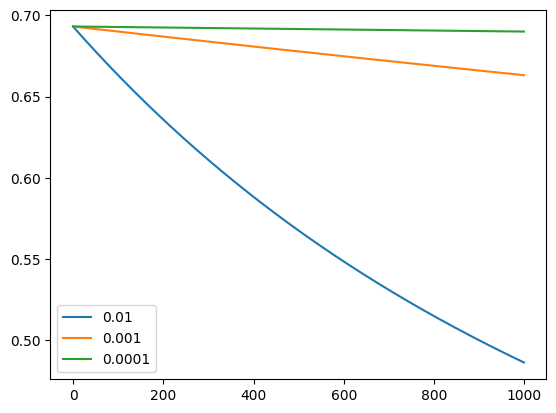

In [24]:
#0.7
losses_gd_tr = []
accuracies_gd_tr = []
precisions_gd_tr = []
recall_gd_tr = []
losses_gd = []
accuracies_gd = []
precisions_gd = []
recall_gd = []

for i in range(10):
    logregGD = LogisticRegressionBGD(threshold = 0.7)
    logregGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_epochs=1000)
    accuracies_gd.append(logregGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_gd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_gd.append(logregGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_gd.append(logregGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_gd_tr.append(logregGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_gd_tr.append(logregGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_gd_tr.append(logregGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_gd_tr.append(logregGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_gd = (2 * np.array(precisions_gd) * np.array(recall_gd)) / (np.array(precisions_gd) + np.array(recall_gd))
f1_gd_tr = (2 * np.array(precisions_gd_tr) * np.array(recall_gd_tr)) / (np.array(precisions_gd_tr) + np.array(recall_gd_tr))
print(f'Train BGD: Loss: {np.mean(losses_gd_tr)}; Accuracy: {np.mean(accuracies_gd_tr)}; Recall: {np.mean(recall_gd_tr)}; Precision: {np.mean(precisions_gd_tr)}; F1: {np.mean(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.mean(losses_gd)}; Accuracy: {np.mean(accuracies_gd)}; Recall: {np.mean(recall_gd)}; Precision: {np.mean(precisions_gd)}; F1: {np.mean(f1_gd)}')
logregBGD = LogisticRegressionBGD(threshold = 0.7)
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
losses1_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
losses2_bgd = logregBGD.losses
logregBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
losses3_bgd = logregBGD.losses
plt.plot(range(len(losses1_bgd)), losses1_bgd, label=0.01)
plt.plot(range(len(losses2_bgd)), losses2_bgd, label=0.001)
plt.plot(range(len(losses3_bgd)), losses3_bgd, label=0.0001)
plt.legend()
print(logregBGD.coeffs)

In [25]:
#Variance for metric parameters
print(f'Train BGD: Loss: {np.std(losses_gd_train)}; Accuracy: {np.std(accuracies_gd_train)}; Recall: {np.std(recall_gd_train)}; Precision: {np.std(precisions_gd_train)}; F1: {np.std(f1_gd_tr)}')
print(f'Test BGD: Loss: {np.std(losses_gd)}; Accuracy: {np.std(accuracies_gd)}; Recall: {np.std(recall_gd)}; Precision: {np.std(precisions_gd)}; F1: {np.std(f1_gd)}')

Train BGD: Loss: 0.005717654217546977; Accuracy: 0.008553464281791576; Recall: 0.008423331817388822; Precision: 0.0021970739486492255; F1: 0.00575185829104325
Test BGD: Loss: 0.006055759438747734; Accuracy: 0.028640180967467593; Recall: 0.028640180967467593; Precision: 0.0; F1: 0.020880022576544664


SGD - threshold 0.5, 0.3, 0.4, 0.6, 0.7 in order


In [26]:
losses_sgd_tr = []
accuracies_sgd_tr = []
precisions_sgd_tr = []
recall_sgd_tr = []
losses_sgd = []
accuracies_sgd = []
precisions_sgd = []
recall_sgd = []

for i in range(10):
    logregSGD = LogisticRegressionSGD()
    logregSGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_iters=1000)
    accuracies_sgd.append(logregSGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_sgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_sgd.append(logregSGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_sgd.append(logregSGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_sgd_tr.append(logregSGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_sgd_tr.append(logregSGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_sgd_tr.append(logregSGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_sgd_tr.append(logregSGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_sgd = (2 * np.array(precisions_sgd) * np.array(recall_sgd)) / (np.array(precisions_sgd) + np.array(recall_sgd))
f1_sgd_tr = (2 * np.array(precisions_sgd_tr) * np.array(recall_sgd_tr)) / (np.array(precisions_sgd_tr) + np.array(recall_sgd_tr))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
print(f'Train SGD: Loss: {np.mean(losses_sgd_tr)}; Accuracy: {np.mean(accuracies_sgd_tr)}; Recall: {np.mean(recall_sgd_tr)}; Precision: {np.mean(precisions_sgd_tr)}; F1: {np.mean(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.mean(losses_sgd)}; Accuracy: {np.mean(accuracies_sgd)}; Recall: {np.mean(recall_sgd)}; Precision: {np.mean(precisions_sgd)}; F1: {np.mean(f1_sgd)}')


Train SGD: Loss: 0.47503691848736124; Accuracy: 0.9035282555060917; Recall: 0.9072554274381357; Precision: 0.9957194186185155; F1: 0.949178322294277
Test SGD: Loss: 0.49797890434768083; Accuracy: 0.8840860277397022; Recall: 0.8885585370334349; Precision: 0.994545896257914; F1: 0.9383846307957043


In [28]:
print(f'Train SGD: Loss: {np.std(losses_sgd_tr)}; Accuracy: {np.std(accuracies_sgd_tr)}; Recall: {np.std(recall_sgd_tr)}; Precision: {np.std(precisions_sgd_tr)}; F1: {np.std(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.std(losses_sgd)}; Accuracy: {np.std(accuracies_sgd)}; Recall: {np.std(recall_sgd)}; Precision: {np.std(precisions_sgd)}; F1: {np.std(f1_sgd)}')

Train SGD: Loss: 0.00672928095082677; Accuracy: 0.02220492320461588; Recall: 0.026059156828546027; Precision: 0.004605962359542444; F1: 0.012104775078718533
Test SGD: Loss: 0.007269122265491829; Accuracy: 0.017571954044063188; Recall: 0.020419089788157842; Precision: 0.008381160002095794; F1: 0.009941634584118175


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.19552232e-02  3.40245011e-03 -4.40140349e-04  3.52230844e-03
  3.57010928e-03 -2.70031278e-03  1.96284158e-03  4.51877337e-03
  5.41554038e-03 -1.96970235e-03 -3.82338066e-03  1.87669439e-03
 -2.24070658e-03  1.69515466e-03  1.90570696e-03 -2.66778843e-03
 -3.53010503e-04 -1.05861085e-04 -3.16181949e-04 -1.89654003e-03
 -1.35146357e-03  5.01055503e-03  4.64468134e-05  4.85929251e-03
  4.92637715e-03 -1.46466044e-03  2.01622067e-03  3.13173081e-03
  5.12256711e-03 -3.52841430e-04 -4.55055871e-04]


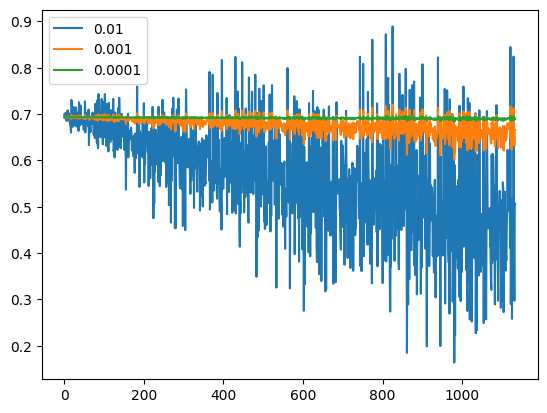

In [29]:
#0.5
logregSGD = LogisticRegressionSGD(threshold = 0.5)
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_iters=1000)
losses1_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_iters=1000)
losses2_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_iters=1000)
losses3_sgd = logregSGD.losses
plt.plot(range(len(losses1_sgd)), losses1_sgd, label=0.01)
plt.plot(range(len(losses2_sgd)), losses2_sgd, label=0.001)
plt.plot(range(len(losses3_sgd)), losses3_sgd, label=0.0001)
plt.legend()
print(logregSGD.coeffs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train SGD: Loss: 0.47503691848736124; Accuracy: 0.5230722748601734; Recall: 1.0; Precision: 0.5230722748601734; F1: 0.6861335292366648
Test SGD: Loss: 0.49797890434768083; Accuracy: 0.5216522743250305; Recall: 1.0; Precision: 0.5216522743250305; F1: 0.6842898901567945


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.19552232e-02  3.40245011e-03 -4.40140349e-04  3.52230844e-03
  3.57010928e-03 -2.70031278e-03  1.96284158e-03  4.51877337e-03
  5.41554038e-03 -1.96970235e-03 -3.82338066e-03  1.87669439e-03
 -2.24070658e-03  1.69515466e-03  1.90570696e-03 -2.66778843e-03
 -3.53010503e-04 -1.05861085e-04 -3.16181949e-04 -1.89654003e-03
 -1.35146357e-03  5.01055503e-03  4.64468134e-05  4.85929251e-03
  4.92637715e-03 -1.46466044e-03  2.01622067e-03  3.13173081e-03
  5.12256711e-03 -3.52841430e-04 -4.55055871e-04]
Train SGD: Loss: 0.00672928095082677; Accuracy: 0.03601306705442315; Recall: 0.0; Precision: 0.03601306705442315; F1: 0.030932282266224187
Test SGD: Loss: 0.007269122265491829; Accuracy: 0.049632077427661715; Recall: 0.0; Precision: 0.049632077427661715; F1: 0.04140989182763212


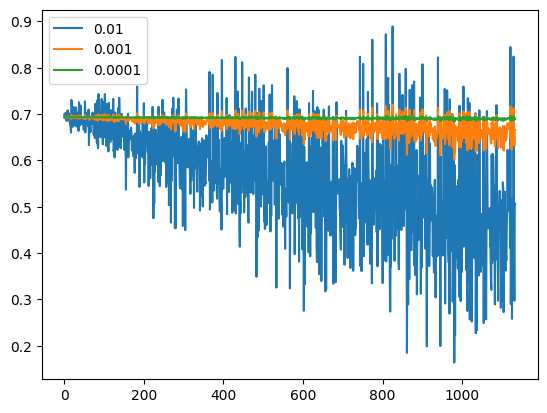

In [30]:
#0.3
losses_sgd_tr = []
accuracies_sgd_tr = []
precisions_sgd_tr = []
recall_sgd_tr = []
losses_sgd = []
accuracies_sgd = []
precisions_sgd = []
recall_sgd = []

for i in range(10):
    logregSGD = LogisticRegressionSGD(threshold = 0.3)
    logregSGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_iters=1000)
    accuracies_sgd.append(logregSGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_sgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_sgd.append(logregSGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_sgd.append(logregSGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_sgd_tr.append(logregSGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_sgd_tr.append(logregSGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_sgd_tr.append(logregSGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_sgd_tr.append(logregSGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_sgd = (2 * np.array(precisions_sgd) * np.array(recall_sgd)) / (np.array(precisions_sgd) + np.array(recall_sgd))
f1_sgd_tr = (2 * np.array(precisions_sgd_tr) * np.array(recall_sgd_tr)) / (np.array(precisions_sgd_tr) + np.array(recall_sgd_tr))
print(f'Train SGD: Loss: {np.mean(losses_sgd_tr)}; Accuracy: {np.mean(accuracies_sgd_tr)}; Recall: {np.mean(recall_sgd_tr)}; Precision: {np.mean(precisions_sgd_tr)}; F1: {np.mean(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.mean(losses_sgd)}; Accuracy: {np.mean(accuracies_sgd)}; Recall: {np.mean(recall_sgd)}; Precision: {np.mean(precisions_sgd)}; F1: {np.mean(f1_sgd)}')
logregSGD = LogisticRegressionSGD(threshold = 0.3)
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_iters=1000)
losses1_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_iters=1000)
losses2_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_iters=1000)
losses3_sgd = logregSGD.losses
plt.plot(range(len(losses1_sgd)), losses1_sgd, label=0.01)
plt.plot(range(len(losses2_sgd)), losses2_sgd, label=0.001)
plt.plot(range(len(losses3_sgd)), losses3_sgd, label=0.0001)
plt.legend()
print(logregSGD.coeffs)
#Variance of metric Parameters
print(f'Train SGD: Loss: {np.std(losses_sgd_tr)}; Accuracy: {np.std(accuracies_sgd_tr)}; Recall: {np.std(recall_sgd_tr)}; Precision: {np.std(precisions_sgd_tr)}; F1: {np.std(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.std(losses_sgd)}; Accuracy: {np.std(accuracies_sgd)}; Recall: {np.std(recall_sgd)}; Precision: {np.std(precisions_sgd)}; F1: {np.std(f1_sgd)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train SGD: Loss: 0.47503691848736124; Accuracy: 0.8755729082275632; Recall: 0.9906300596422982; Precision: 0.8831688223855909; F1: 0.9332626896908609
Test SGD: Loss: 0.49797890434768083; Accuracy: 0.882084473807194; Recall: 0.9848268731303358; Precision: 0.8944722174078713; F1: 0.9368786899476408


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.19552232e-02  3.40245011e-03 -4.40140349e-04  3.52230844e-03
  3.57010928e-03 -2.70031278e-03  1.96284158e-03  4.51877337e-03
  5.41554038e-03 -1.96970235e-03 -3.82338066e-03  1.87669439e-03
 -2.24070658e-03  1.69515466e-03  1.90570696e-03 -2.66778843e-03
 -3.53010503e-04 -1.05861085e-04 -3.16181949e-04 -1.89654003e-03
 -1.35146357e-03  5.01055503e-03  4.64468134e-05  4.85929251e-03
  4.92637715e-03 -1.46466044e-03  2.01622067e-03  3.13173081e-03
  5.12256711e-03 -3.52841430e-04 -4.55055871e-04]


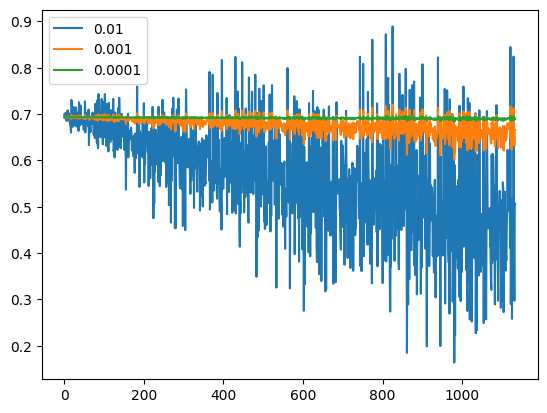

In [31]:
#0.4
losses_sgd_tr = []
accuracies_sgd_tr = []
precisions_sgd_tr = []
recall_sgd_tr = []
losses_sgd = []
accuracies_sgd = []
precisions_sgd = []
recall_sgd = []

for i in range(10):
    logregSGD = LogisticRegressionSGD(threshold = 0.4)
    logregSGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_iters=1000)
    accuracies_sgd.append(logregSGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_sgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_sgd.append(logregSGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_sgd.append(logregSGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_sgd_tr.append(logregSGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_sgd_tr.append(logregSGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_sgd_tr.append(logregSGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_sgd_tr.append(logregSGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_sgd = (2 * np.array(precisions_sgd) * np.array(recall_sgd)) / (np.array(precisions_sgd) + np.array(recall_sgd))
f1_sgd_tr = (2 * np.array(precisions_sgd_tr) * np.array(recall_sgd_tr)) / (np.array(precisions_sgd_tr) + np.array(recall_sgd_tr))
print(f'Train SGD: Loss: {np.mean(losses_sgd_tr)}; Accuracy: {np.mean(accuracies_sgd_tr)}; Recall: {np.mean(recall_sgd_tr)}; Precision: {np.mean(precisions_sgd_tr)}; F1: {np.mean(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.mean(losses_sgd)}; Accuracy: {np.mean(accuracies_sgd)}; Recall: {np.mean(recall_sgd)}; Precision: {np.mean(precisions_sgd)}; F1: {np.mean(f1_sgd)}')
logregSGD = LogisticRegressionSGD(threshold = 0.4)
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_iters=1000)
losses1_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_iters=1000)
losses2_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_iters=1000)
losses3_sgd = logregSGD.losses
plt.plot(range(len(losses1_sgd)), losses1_sgd, label=0.01)
plt.plot(range(len(losses2_sgd)), losses2_sgd, label=0.001)
plt.plot(range(len(losses3_sgd)), losses3_sgd, label=0.0001)
plt.legend()
print(logregSGD.coeffs)


In [32]:
#Variance of metric Parameters
print(f'Train SGD: Loss: {np.std(losses_sgd_tr)}; Accuracy: {np.std(accuracies_sgd_tr)}; Recall: {np.std(recall_sgd_tr)}; Precision: {np.std(precisions_sgd_tr)}; F1: {np.std(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.std(losses_sgd)}; Accuracy: {np.std(accuracies_sgd)}; Recall: {np.std(recall_sgd)}; Precision: {np.std(precisions_sgd)}; F1: {np.std(f1_sgd)}')

Train SGD: Loss: 0.00672928095082677; Accuracy: 0.035697829997266874; Recall: 0.004989888685575715; Precision: 0.039035654423213745; F1: 0.02083685349090638
Test SGD: Loss: 0.007269122265491829; Accuracy: 0.039349548831793535; Recall: 0.007888444264224236; Precision: 0.042253739901636105; F1: 0.022475724199560183


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train SGD: Loss: 0.47503691848736124; Accuracy: 0.7870158609777167; Recall: 0.7870158609777167; Precision: 1.0; F1: 0.880406678129258
Test SGD: Loss: 0.49797890434768083; Accuracy: 0.7566757227344162; Recall: 0.7566757227344162; Precision: 1.0; F1: 0.8611417169440585


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.19552232e-02  3.40245011e-03 -4.40140349e-04  3.52230844e-03
  3.57010928e-03 -2.70031278e-03  1.96284158e-03  4.51877337e-03
  5.41554038e-03 -1.96970235e-03 -3.82338066e-03  1.87669439e-03
 -2.24070658e-03  1.69515466e-03  1.90570696e-03 -2.66778843e-03
 -3.53010503e-04 -1.05861085e-04 -3.16181949e-04 -1.89654003e-03
 -1.35146357e-03  5.01055503e-03  4.64468134e-05  4.85929251e-03
  4.92637715e-03 -1.46466044e-03  2.01622067e-03  3.13173081e-03
  5.12256711e-03 -3.52841430e-04 -4.55055871e-04]


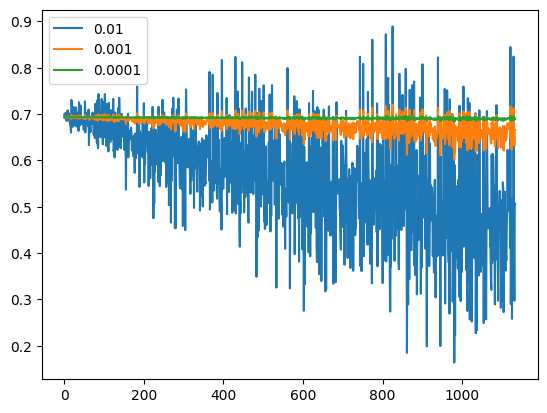

In [33]:
#0.6
losses_sgd_tr = []
accuracies_sgd_tr = []
precisions_sgd_tr = []
recall_sgd_tr = []
losses_sgd = []
accuracies_sgd = []
precisions_sgd = []
recall_sgd = []

for i in range(10):
    logregSGD = LogisticRegressionSGD(threshold = 0.6)
    logregSGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_iters=1000)
    accuracies_sgd.append(logregSGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_sgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_sgd.append(logregSGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_sgd.append(logregSGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_sgd_tr.append(logregSGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_sgd_tr.append(logregSGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_sgd_tr.append(logregSGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_sgd_tr.append(logregSGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_sgd = (2 * np.array(precisions_sgd) * np.array(recall_sgd)) / (np.array(precisions_sgd) + np.array(recall_sgd))
f1_sgd_tr = (2 * np.array(precisions_sgd_tr) * np.array(recall_sgd_tr)) / (np.array(precisions_sgd_tr) + np.array(recall_sgd_tr))
print(f'Train SGD: Loss: {np.mean(losses_sgd_tr)}; Accuracy: {np.mean(accuracies_sgd_tr)}; Recall: {np.mean(recall_sgd_tr)}; Precision: {np.mean(precisions_sgd_tr)}; F1: {np.mean(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.mean(losses_sgd)}; Accuracy: {np.mean(accuracies_sgd)}; Recall: {np.mean(recall_sgd)}; Precision: {np.mean(precisions_sgd)}; F1: {np.mean(f1_sgd)}')
logregSGD = LogisticRegressionSGD(threshold = 0.6)
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_iters=1000)
losses1_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_iters=1000)
losses2_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_iters=1000)
losses3_sgd = logregSGD.losses
plt.plot(range(len(losses1_sgd)), losses1_sgd, label=0.01)
plt.plot(range(len(losses2_sgd)), losses2_sgd, label=0.001)
plt.plot(range(len(losses3_sgd)), losses3_sgd, label=0.0001)
plt.legend()
print(logregSGD.coeffs)

In [34]:
#Variance of metric Parameters
print(f'Train SGD: Loss: {np.std(losses_sgd_tr)}; Accuracy: {np.std(accuracies_sgd_tr)}; Recall: {np.std(recall_sgd_tr)}; Precision: {np.std(precisions_sgd_tr)}; F1: {np.std(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.std(losses_sgd)}; Accuracy: {np.std(accuracies_sgd)}; Recall: {np.std(recall_sgd)}; Precision: {np.std(precisions_sgd)}; F1: {np.std(f1_sgd)}')

Train SGD: Loss: 0.00672928095082677; Accuracy: 0.03466828976216123; Recall: 0.03466828976216123; Precision: 0.0; F1: 0.021092351977010426
Test SGD: Loss: 0.007269122265491829; Accuracy: 0.030678429582680272; Recall: 0.030678429582680272; Precision: 0.0; F1: 0.019714969968296456


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train SGD: Loss: 0.47503691848736124; Accuracy: 0.6853435987746929; Recall: 0.6853435987746929; Precision: 1.0; F1: 0.8131300652725223
Test SGD: Loss: 0.49797890434768083; Accuracy: 0.6662103711671981; Recall: 0.6662103711671981; Precision: 1.0; F1: 0.7992309181371879


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.19552232e-02  3.40245011e-03 -4.40140349e-04  3.52230844e-03
  3.57010928e-03 -2.70031278e-03  1.96284158e-03  4.51877337e-03
  5.41554038e-03 -1.96970235e-03 -3.82338066e-03  1.87669439e-03
 -2.24070658e-03  1.69515466e-03  1.90570696e-03 -2.66778843e-03
 -3.53010503e-04 -1.05861085e-04 -3.16181949e-04 -1.89654003e-03
 -1.35146357e-03  5.01055503e-03  4.64468134e-05  4.85929251e-03
  4.92637715e-03 -1.46466044e-03  2.01622067e-03  3.13173081e-03
  5.12256711e-03 -3.52841430e-04 -4.55055871e-04]


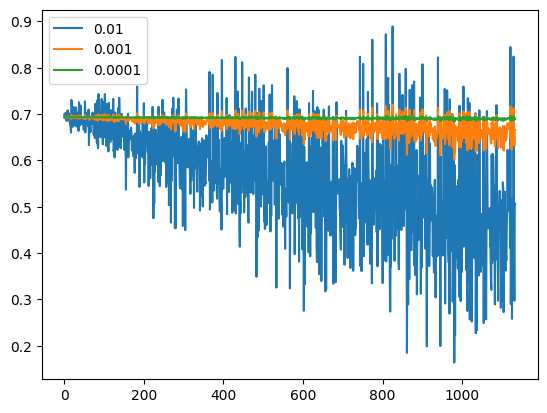

In [35]:
#0.7
losses_sgd_tr = []
accuracies_sgd_tr = []
precisions_sgd_tr = []
recall_sgd_tr = []
losses_sgd = []
accuracies_sgd = []
precisions_sgd = []
recall_sgd = []

for i in range(10):
    logregSGD = LogisticRegressionSGD(threshold = 0.7)
    logregSGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, max_iters=1000)
    accuracies_sgd.append(logregSGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_sgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_sgd.append(logregSGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_sgd.append(logregSGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_sgd_tr.append(logregSGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_sgd_tr.append(logregSGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_sgd_tr.append(logregSGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_sgd_tr.append(logregSGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_sgd = (2 * np.array(precisions_sgd) * np.array(recall_sgd)) / (np.array(precisions_sgd) + np.array(recall_sgd))
f1_sgd_tr = (2 * np.array(precisions_sgd_tr) * np.array(recall_sgd_tr)) / (np.array(precisions_sgd_tr) + np.array(recall_sgd_tr))
print(f'Train SGD: Loss: {np.mean(losses_sgd_tr)}; Accuracy: {np.mean(accuracies_sgd_tr)}; Recall: {np.mean(recall_sgd_tr)}; Precision: {np.mean(precisions_sgd_tr)}; F1: {np.mean(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.mean(losses_sgd)}; Accuracy: {np.mean(accuracies_sgd)}; Recall: {np.mean(recall_sgd)}; Precision: {np.mean(precisions_sgd)}; F1: {np.mean(f1_sgd)}')
logregSGD = LogisticRegressionSGD(threshold = 0.7)
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_iters=1000)
losses1_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_iters=1000)
losses2_sgd = logregSGD.losses
logregSGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_iters=1000)
losses3_sgd = logregSGD.losses
plt.plot(range(len(losses1_sgd)), losses1_sgd, label=0.01)
plt.plot(range(len(losses2_sgd)), losses2_sgd, label=0.001)
plt.plot(range(len(losses3_sgd)), losses3_sgd, label=0.0001)
plt.legend()
print(logregSGD.coeffs)

In [36]:
#Variance of metric Parameters
print(f'Train SGD: Loss: {np.std(losses_sgd_tr)}; Accuracy: {np.std(accuracies_sgd_tr)}; Recall: {np.std(recall_sgd_tr)}; Precision: {np.std(precisions_sgd_tr)}; F1: {np.std(f1_sgd_tr)}')
print(f'Test SGD: Loss: {np.std(losses_sgd)}; Accuracy: {np.std(accuracies_sgd)}; Recall: {np.std(recall_sgd)}; Precision: {np.std(precisions_sgd)}; F1: {np.std(f1_sgd)}')

Train SGD: Loss: 0.00672928095082677; Accuracy: 0.020244943985749303; Recall: 0.020244943985749303; Precision: 0.0; F1: 0.014011623246155588
Test SGD: Loss: 0.007269122265491829; Accuracy: 0.03193652960358468; Recall: 0.03193652960358468; Precision: 0.0; F1: 0.0229850046500319


MBGD - threshold 0.5, 0.3, 0.4, 0.6 and 0.7 in order



In [37]:
losses_mbgd_tr = []
accuracies_mbgd_tr = []
precisions_mbgd_tr = []
recall_mbgd_tr = []
losses_mbgd = []
accuracies_mbgd = []
precisions_mbgd = []
recall_mbgd = []

for i in range(10):
    logregMBGD = LogisticRegressionMBGD()
    logregMBGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, batch_size = 20,max_epochs=1000)
    accuracies_mbgd.append(logregMBGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_mbgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_mbgd.append(logregMBGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_mbgd.append(logregMBGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_mbgd_tr.append(logregMBGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_mbgd_tr.append(logregMBGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_mbgd_tr.append(logregMBGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_mbgd_tr.append(logregMBGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_mbgd = (2 * np.array(precisions_mbgd) * np.array(recall_mbgd)) / (np.array(precisions_mbgd) + np.array(recall_mbgd))
f1_mbgd_tr = (2 * np.array(precisions_mbgd_tr) * np.array(recall_mbgd_tr)) / (np.array(precisions_mbgd_tr) + np.array(recall_mbgd_tr))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
print(f'Train MBGD: Loss: {np.mean(losses_mbgd_tr)}; Accuracy: {np.mean(accuracies_mbgd_tr)}; Recall: {np.mean(recall_mbgd_tr)}; Precision: {np.mean(precisions_mbgd_tr)}; F1: {np.mean(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.mean(losses_mbgd)}; Accuracy: {np.mean(accuracies_mbgd)}; Recall: {np.mean(recall_mbgd)}; Precision: {np.mean(precisions_mbgd)}; F1: {np.mean(f1_mbgd)}')


Train MBGD: Loss: 0.49151961759136864; Accuracy: 0.9065717554676601; Recall: 0.9085138942445609; Precision: 0.9976489293948532; F1: 0.9509755919245448
Test MBGD: Loss: 0.49797890434768083; Accuracy: 0.8817970587123259; Recall: 0.885228286346789; Precision: 0.995676338375403; F1: 0.9370386198210161


In [39]:
#0.5
logregMBGD = LogisticRegressionMBGD(threshold = 0.5)
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
loss1_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
loss2_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
loss3_mbgd = logregMBGD.losses

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
len(loss1_mbgd)

19000

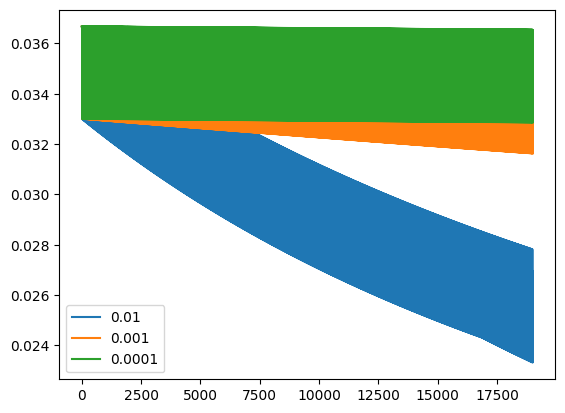

In [41]:
plt.plot(range(len(loss1_mbgd)), loss1_mbgd, label=0.01)
plt.plot(range(len(loss2_mbgd)), loss2_mbgd, label=0.001)
plt.plot(range(len(loss3_mbgd)), loss3_mbgd, label=0.0001)
plt.legend()

In [42]:
logregMBGD.coeffs

array([-1.05403699e-02,  3.00287931e-03, -3.87325535e-04,  3.10860304e-03,
        3.15024284e-03, -2.37974106e-03,  1.73267233e-03,  3.98701365e-03,
        4.77824310e-03, -1.73559478e-03, -3.37121429e-03,  1.65600496e-03,
       -1.97573153e-03,  1.49587930e-03,  1.68139641e-03, -2.35243024e-03,
       -3.10589259e-04, -9.28558169e-05, -2.77448238e-04, -1.67199075e-03,
       -1.19152937e-03,  4.42131663e-03,  4.20215064e-05,  4.28787216e-03,
        4.34659642e-03, -1.29026118e-03,  1.77934965e-03,  2.76344674e-03,
        4.52049131e-03, -3.09894185e-04, -4.00732587e-04])

In [43]:
#Variance of metrics
print(f'Train MBGD: Loss: {np.std(losses_mbgd_tr)}; Accuracy: {np.std(accuracies_mbgd_tr)}; Recall: {np.std(recall_mbgd_tr)}; Precision: {np.std(precisions_mbgd_tr)}; F1: {np.std(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.std(losses_mbgd)}; Accuracy: {np.std(accuracies_mbgd)}; Recall: {np.std(recall_mbgd)}; Precision: {np.std(precisions_mbgd)}; F1: {np.std(f1_mbgd)}')

Train MBGD: Loss: 0.0057168627434536195; Accuracy: 0.008553464281791576; Recall: 0.008423331817388822; Precision: 0.0021970739486492255; F1: 0.004712448997714552
Test MBGD: Loss: 0.007269122265491829; Accuracy: 0.02218702411150722; Recall: 0.022860182739549595; Precision: 0.003912829691475956; F1: 0.01251317109271499


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train MBGD: Loss: 0.49151961759136864; Accuracy: 0.46668990341761374; Recall: 1.0; Precision: 0.46668990341761374; F1: 0.6362728665141246
Test MBGD: Loss: 0.49797890434768083; Accuracy: 0.46992159338973166; Recall: 1.0; Precision: 0.46992159338973166; F1: 0.6388021760807876


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.05403699e-02  3.00287931e-03 -3.87325535e-04  3.10860304e-03
  3.15024284e-03 -2.37974106e-03  1.73267233e-03  3.98701365e-03
  4.77824310e-03 -1.73559478e-03 -3.37121429e-03  1.65600496e-03
 -1.97573153e-03  1.49587930e-03  1.68139641e-03 -2.35243024e-03
 -3.10589259e-04 -9.28558169e-05 -2.77448238e-04 -1.67199075e-03
 -1.19152937e-03  4.42131663e-03  4.20215064e-05  4.28787216e-03
  4.34659642e-03 -1.29026118e-03  1.77934965e-03  2.76344674e-03
  4.52049131e-03 -3.09894185e-04 -4.00732587e-04]
Train MBGD: Loss: 0.0057168627434536195; Accuracy: 0.013315477146151522; Recall: 0.0; Precision: 0.013315477146151522; F1: 0.012378368325956972
Test MBGD: Loss: 0.007269122265491829; Accuracy: 0.030665580838672244; Recall: 0.0; Precision: 0.030665580838672244; F1: 0.027857500602224458


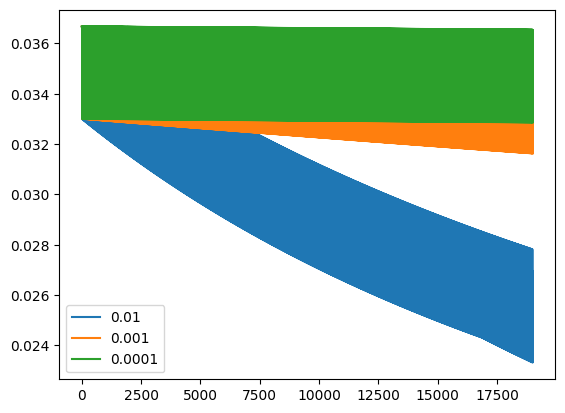

In [44]:
#0.3
losses_mbgd_tr = []
accuracies_mbgd_tr = []
precisions_mbgd_tr = []
recall_mbgd_tr = []
losses_mbgd = []
accuracies_mbgd = []
precisions_mbgd = []
recall_mbgd = []

for i in range(10):
    logregMBGD = LogisticRegressionMBGD(threshold = 0.3)
    logregMBGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, batch_size = 20,max_epochs=1000)
    accuracies_mbgd.append(logregMBGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_mbgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_mbgd.append(logregMBGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_mbgd.append(logregMBGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_mbgd_tr.append(logregMBGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_mbgd_tr.append(logregMBGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_mbgd_tr.append(logregMBGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_mbgd_tr.append(logregMBGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_mbgd = (2 * np.array(precisions_mbgd) * np.array(recall_mbgd)) / (np.array(precisions_mbgd) + np.array(recall_mbgd))
f1_mbgd_tr = (2 * np.array(precisions_mbgd_tr) * np.array(recall_mbgd_tr)) / (np.array(precisions_mbgd_tr) + np.array(recall_mbgd_tr))
print(f'Train MBGD: Loss: {np.mean(losses_mbgd_tr)}; Accuracy: {np.mean(accuracies_mbgd_tr)}; Recall: {np.mean(recall_mbgd_tr)}; Precision: {np.mean(precisions_mbgd_tr)}; F1: {np.mean(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.mean(losses_mbgd)}; Accuracy: {np.mean(accuracies_mbgd)}; Recall: {np.mean(recall_mbgd)}; Precision: {np.mean(precisions_mbgd)}; F1: {np.mean(f1_mbgd)}')
logregMBGD = LogisticRegressionMBGD(threshold = 0.3)
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
loss1_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
loss2_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
loss3_mbgd = logregMBGD.losses
plt.plot(range(len(loss1_mbgd)), loss1_mbgd, label=0.01)
plt.plot(range(len(loss2_mbgd)), loss2_mbgd, label=0.001)
plt.plot(range(len(loss3_mbgd)), loss3_mbgd, label=0.0001)
plt.legend()
print(logregMBGD.coeffs)
#Variance of metrics
print(f'Train MBGD: Loss: {np.std(losses_mbgd_tr)}; Accuracy: {np.std(accuracies_mbgd_tr)}; Recall: {np.std(recall_mbgd_tr)}; Precision: {np.std(precisions_mbgd_tr)}; F1: {np.std(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.std(losses_mbgd)}; Accuracy: {np.std(accuracies_mbgd)}; Recall: {np.std(recall_mbgd)}; Precision: {np.std(precisions_mbgd)}; F1: {np.std(f1_mbgd)}')


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train MBGD: Loss: 0.49151961759136864; Accuracy: 0.8522295000286834; Recall: 0.9938369727747342; Precision: 0.8568299342572703; F1: 0.9201004594657153
Test MBGD: Loss: 0.49797890434768083; Accuracy: 0.8622174444361275; Recall: 0.9875281071983417; Precision: 0.8718116115104536; F1: 0.9257401645186736


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.05403699e-02  3.00287931e-03 -3.87325535e-04  3.10860304e-03
  3.15024284e-03 -2.37974106e-03  1.73267233e-03  3.98701365e-03
  4.77824310e-03 -1.73559478e-03 -3.37121429e-03  1.65600496e-03
 -1.97573153e-03  1.49587930e-03  1.68139641e-03 -2.35243024e-03
 -3.10589259e-04 -9.28558169e-05 -2.77448238e-04 -1.67199075e-03
 -1.19152937e-03  4.42131663e-03  4.20215064e-05  4.28787216e-03
  4.34659642e-03 -1.29026118e-03  1.77934965e-03  2.76344674e-03
  4.52049131e-03 -3.09894185e-04 -4.00732587e-04]


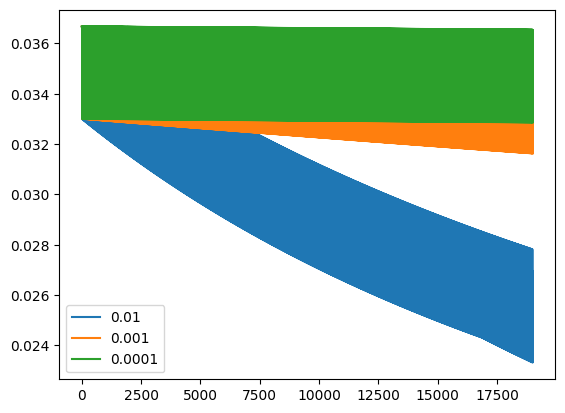

In [45]:
#0.4
losses_mbgd_tr = []
accuracies_mbgd_tr = []
precisions_mbgd_tr = []
recall_mbgd_tr = []
losses_mbgd = []
accuracies_mbgd = []
precisions_mbgd = []
recall_mbgd = []

for i in range(10):
    logregMBGD = LogisticRegressionMBGD(threshold = 0.4)
    logregMBGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, batch_size = 20,max_epochs=1000)
    accuracies_mbgd.append(logregMBGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_mbgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_mbgd.append(logregMBGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_mbgd.append(logregMBGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_mbgd_tr.append(logregMBGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_mbgd_tr.append(logregMBGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_mbgd_tr.append(logregMBGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_mbgd_tr.append(logregMBGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_mbgd = (2 * np.array(precisions_mbgd) * np.array(recall_mbgd)) / (np.array(precisions_mbgd) + np.array(recall_mbgd))
f1_mbgd_tr = (2 * np.array(precisions_mbgd_tr) * np.array(recall_mbgd_tr)) / (np.array(precisions_mbgd_tr) + np.array(recall_mbgd_tr))
print(f'Train MBGD: Loss: {np.mean(losses_mbgd_tr)}; Accuracy: {np.mean(accuracies_mbgd_tr)}; Recall: {np.mean(recall_mbgd_tr)}; Precision: {np.mean(precisions_mbgd_tr)}; F1: {np.mean(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.mean(losses_mbgd)}; Accuracy: {np.mean(accuracies_mbgd)}; Recall: {np.mean(recall_mbgd)}; Precision: {np.mean(precisions_mbgd)}; F1: {np.mean(f1_mbgd)}')
logregMBGD = LogisticRegressionMBGD(threshold = 0.4)
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
loss1_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
loss2_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
loss3_mbgd = logregMBGD.losses
plt.plot(range(len(loss1_mbgd)), loss1_mbgd, label=0.01)
plt.plot(range(len(loss2_mbgd)), loss2_mbgd, label=0.001)
plt.plot(range(len(loss3_mbgd)), loss3_mbgd, label=0.0001)
plt.legend()
print(logregMBGD.coeffs)

In [46]:
#Variance of metrics
print(f'Train MBGD: Loss: {np.std(losses_mbgd_tr)}; Accuracy: {np.std(accuracies_mbgd_tr)}; Recall: {np.std(recall_mbgd_tr)}; Precision: {np.std(precisions_mbgd_tr)}; F1: {np.std(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.std(losses_mbgd)}; Accuracy: {np.std(accuracies_mbgd)}; Recall: {np.std(recall_mbgd)}; Precision: {np.std(precisions_mbgd)}; F1: {np.std(f1_mbgd)}')

Train MBGD: Loss: 0.0057168627434536195; Accuracy: 0.019489385040568255; Recall: 0.0038271424398292836; Precision: 0.02096956233554368; F1: 0.011380208210115565
Test MBGD: Loss: 0.007269122265491829; Accuracy: 0.02969318631450349; Recall: 0.006462913700218092; Precision: 0.031245222254359627; F1: 0.017023587099515604


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train MBGD: Loss: 0.49151961759136864; Accuracy: 0.7742317821844198; Recall: 0.7742317821844198; Precision: 1.0; F1: 0.872619081203206
Test MBGD: Loss: 0.49797890434768083; Accuracy: 0.7436083788116367; Recall: 0.7436083788116367; Precision: 1.0; F1: 0.8526748970184685


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.05403699e-02  3.00287931e-03 -3.87325535e-04  3.10860304e-03
  3.15024284e-03 -2.37974106e-03  1.73267233e-03  3.98701365e-03
  4.77824310e-03 -1.73559478e-03 -3.37121429e-03  1.65600496e-03
 -1.97573153e-03  1.49587930e-03  1.68139641e-03 -2.35243024e-03
 -3.10589259e-04 -9.28558169e-05 -2.77448238e-04 -1.67199075e-03
 -1.19152937e-03  4.42131663e-03  4.20215064e-05  4.28787216e-03
  4.34659642e-03 -1.29026118e-03  1.77934965e-03  2.76344674e-03
  4.52049131e-03 -3.09894185e-04 -4.00732587e-04]


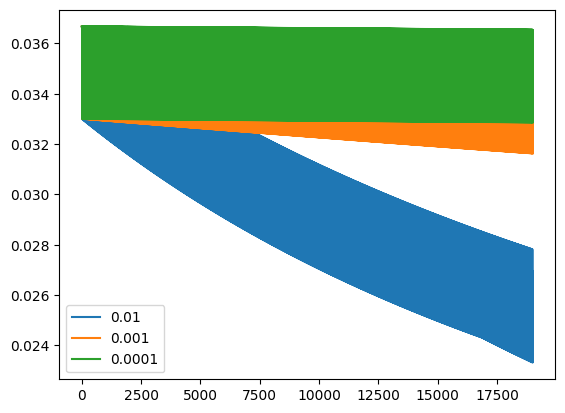

In [47]:
#0.6
losses_mbgd_tr = []
accuracies_mbgd_tr = []
precisions_mbgd_tr = []
recall_mbgd_tr = []
losses_mbgd = []
accuracies_mbgd = []
precisions_mbgd = []
recall_mbgd = []

for i in range(10):
    logregMBGD = LogisticRegressionMBGD(threshold = 0.6)
    logregMBGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, batch_size = 20,max_epochs=1000)
    accuracies_mbgd.append(logregMBGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_mbgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_mbgd.append(logregMBGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_mbgd.append(logregMBGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_mbgd_tr.append(logregMBGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_mbgd_tr.append(logregMBGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_mbgd_tr.append(logregMBGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_mbgd_tr.append(logregMBGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_mbgd = (2 * np.array(precisions_mbgd) * np.array(recall_mbgd)) / (np.array(precisions_mbgd) + np.array(recall_mbgd))
f1_mbgd_tr = (2 * np.array(precisions_mbgd_tr) * np.array(recall_mbgd_tr)) / (np.array(precisions_mbgd_tr) + np.array(recall_mbgd_tr))
print(f'Train MBGD: Loss: {np.mean(losses_mbgd_tr)}; Accuracy: {np.mean(accuracies_mbgd_tr)}; Recall: {np.mean(recall_mbgd_tr)}; Precision: {np.mean(precisions_mbgd_tr)}; F1: {np.mean(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.mean(losses_mbgd)}; Accuracy: {np.mean(accuracies_mbgd)}; Recall: {np.mean(recall_mbgd)}; Precision: {np.mean(precisions_mbgd)}; F1: {np.mean(f1_mbgd)}')
logregMBGD = LogisticRegressionMBGD(threshold = 0.6)
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
loss1_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
loss2_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
loss3_mbgd = logregMBGD.losses
plt.plot(range(len(loss1_mbgd)), loss1_mbgd, label=0.01)
plt.plot(range(len(loss2_mbgd)), loss2_mbgd, label=0.001)
plt.plot(range(len(loss3_mbgd)), loss3_mbgd, label=0.0001)
plt.legend()
print(logregMBGD.coeffs)


In [48]:
#Variance of metrics
print(f'Train MBGD: Loss: {np.std(losses_mbgd_tr)}; Accuracy: {np.std(accuracies_mbgd_tr)}; Recall: {np.std(recall_mbgd_tr)}; Precision: {np.std(precisions_mbgd_tr)}; F1: {np.std(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.std(losses_mbgd)}; Accuracy: {np.std(accuracies_mbgd)}; Recall: {np.std(recall_mbgd)}; Precision: {np.std(precisions_mbgd)}; F1: {np.std(f1_mbgd)}')

Train MBGD: Loss: 0.0057168627434536195; Accuracy: 0.019261670978315965; Recall: 0.019261670978315965; Precision: 0.0; F1: 0.012204215679051356
Test MBGD: Loss: 0.007269122265491829; Accuracy: 0.027152648689248365; Recall: 0.027152648689248365; Precision: 0.0; F1: 0.01788913970370587


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Train MBGD: Loss: 0.49151961759136864; Accuracy: 0.6712599796849793; Recall: 0.6712599796849793; Precision: 1.0; F1: 0.8032705075999418
Test MBGD: Loss: 0.49797890434768083; Accuracy: 0.6571133887783897; Recall: 0.6571133887783897; Precision: 1.0; F1: 0.7927212120678184


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[-1.05403699e-02  3.00287931e-03 -3.87325535e-04  3.10860304e-03
  3.15024284e-03 -2.37974106e-03  1.73267233e-03  3.98701365e-03
  4.77824310e-03 -1.73559478e-03 -3.37121429e-03  1.65600496e-03
 -1.97573153e-03  1.49587930e-03  1.68139641e-03 -2.35243024e-03
 -3.10589259e-04 -9.28558169e-05 -2.77448238e-04 -1.67199075e-03
 -1.19152937e-03  4.42131663e-03  4.20215064e-05  4.28787216e-03
  4.34659642e-03 -1.29026118e-03  1.77934965e-03  2.76344674e-03
  4.52049131e-03 -3.09894185e-04 -4.00732587e-04]


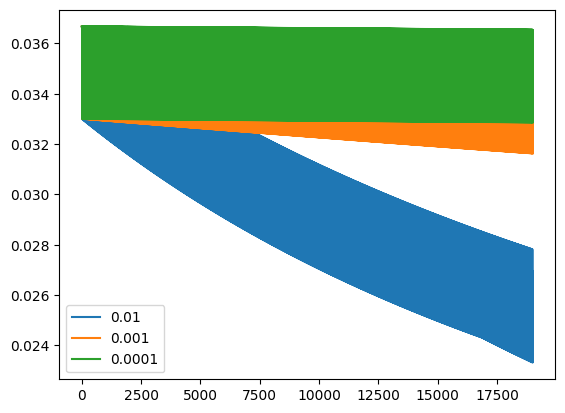

In [49]:
#0.7
losses_mbgd_tr = []
accuracies_mbgd_tr = []
precisions_mbgd_tr = []
recall_mbgd_tr = []
losses_mbgd = []
accuracies_mbgd = []
precisions_mbgd = []
recall_mbgd = []

for i in range(10):
    logregMBGD = LogisticRegressionMBGD(threshold = 0.7)
    logregMBGD.fit(X_train_list[i], y_train_list[i], alpha=0.01, batch_size = 20,max_epochs=1000)
    accuracies_mbgd.append(logregMBGD.evaluate(X_test_list[i], y_test_list[i]))
    losses_mbgd.append(logregGD.get_loss(X_test_list[i], y_test_list[i]))
    precisions_mbgd.append(logregMBGD.get_precision(X_test_list[i], y_test_list[i]))
    recall_mbgd.append(logregMBGD.get_recall(X_test_list[i], y_test_list[i]))
    accuracies_mbgd_tr.append(logregMBGD.evaluate(X_train_list[i], y_train_list[i]))
    losses_mbgd_tr.append(logregMBGD.get_loss(X_train_list[i], y_train_list[i]))
    precisions_mbgd_tr.append(logregMBGD.get_precision(X_train_list[i], y_train_list[i]))
    recall_mbgd_tr.append(logregMBGD.get_recall(X_train_list[i], y_train_list[i]))
    
f1_mbgd = (2 * np.array(precisions_mbgd) * np.array(recall_mbgd)) / (np.array(precisions_mbgd) + np.array(recall_mbgd))
f1_mbgd_tr = (2 * np.array(precisions_mbgd_tr) * np.array(recall_mbgd_tr)) / (np.array(precisions_mbgd_tr) + np.array(recall_mbgd_tr))
print(f'Train MBGD: Loss: {np.mean(losses_mbgd_tr)}; Accuracy: {np.mean(accuracies_mbgd_tr)}; Recall: {np.mean(recall_mbgd_tr)}; Precision: {np.mean(precisions_mbgd_tr)}; F1: {np.mean(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.mean(losses_mbgd)}; Accuracy: {np.mean(accuracies_mbgd)}; Recall: {np.mean(recall_mbgd)}; Precision: {np.mean(precisions_mbgd)}; F1: {np.mean(f1_mbgd)}')
logregMBGD = LogisticRegressionMBGD(threshold = 0.7)
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.01, max_epochs=1000)
loss1_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.001, max_epochs=1000)
loss2_mbgd = logregMBGD.losses
logregMBGD.fit(X_train_list[0], y_train_list[0], alpha=0.0001, max_epochs=1000)
loss3_mbgd = logregMBGD.losses
plt.plot(range(len(loss1_mbgd)), loss1_mbgd, label=0.01)
plt.plot(range(len(loss2_mbgd)), loss2_mbgd, label=0.001)
plt.plot(range(len(loss3_mbgd)), loss3_mbgd, label=0.0001)
plt.legend()
print(logregMBGD.coeffs)


In [50]:
#Variance of metrics
print(f'Train MBGD: Loss: {np.std(losses_mbgd_tr)}; Accuracy: {np.std(accuracies_mbgd_tr)}; Recall: {np.std(recall_mbgd_tr)}; Precision: {np.std(precisions_mbgd_tr)}; F1: {np.std(f1_mbgd_tr)}')
print(f'Test MBGD: Loss: {np.std(losses_mbgd)}; Accuracy: {np.std(accuracies_mbgd)}; Recall: {np.std(recall_mbgd)}; Precision: {np.std(precisions_mbgd)}; F1: {np.std(f1_mbgd)}')

Train MBGD: Loss: 0.0057168627434536195; Accuracy: 0.008025484831023107; Recall: 0.008025484831023107; Precision: 0.0; F1: 0.005745118287953786
Test MBGD: Loss: 0.007269122265491829; Accuracy: 0.028640180967467593; Recall: 0.028640180967467593; Precision: 0.0; F1: 0.020880022576544664
